<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: West Nile Virus Prediction

# Background

West Nile Virus(WNV) is most commonly spread to humans through infected mosquitoes. Around 20% of the people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

In 2002, the first human case of the WNV was reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health(CDPH) had established a comprehensive surveillance and control program that is still in effect today.

Due to the rising seasonal epidemic of the WNV in Chicago, an increasing number of people need medical attention. As such, there is a need for better mosquito control. However, the City of Chicago can only react to the new cases and spraying pesticide is costly and must be done regularly.

# Problem Statement

Build a classification model of at least 90% recall score to predict areas of the city where there are mosquitoes carrying the West Nile Virus. Optimise current mosquito control measures to effectively and efficiently tackle the mosquito problem and create a desirable cost-benefit analysis.

## This notebook consists of Exploratory Data Analysis. Please refer to the relevant notebooks for the other parts.

### Contents:
- **Data Dictionary**
- **Data Cleaning** - *refer to part 1 Data Cleaning notebook*
- **Exploratory Data Analysis & Visualisaion** 
- **Modelling** - *refer to part 3 Modelling notebook*
- **Spray Analysis** - *refer to part 4 spray analysis and conclusion notebook*
- **Conclusion and Recommendations** - *refer to part 4 spray analysis and conclusion notebook*

# Data Dictionary

#### train.csv, test.csv

* The train set consists of data from 2007, 2009, 2011, and 2013
* The test set consists of data from 2008, 2010, 2012 and 2014 (without data on NumMosquitos and WnvPresent)


---
| Feature | Data Type | Description |
| :--- | :--- | :--- 
| **Date**| *object* | Date that the WNV test is performed |
| **Address** | *object* | Approximate address of the location of trap. This is used to send to the GeoCoder. |
| **Species** | *object* | The species of mosquitos |
| **Block** | *int* | Block number of address |
| **Street** | *object* | Street name |
| **Trap** | *object* | Id of the trap |
| **AddressNumberAndStreet** | *object* | Approximate address returned from GeoCoder |
| **Latitude** | *float* | Latitude returned from GeoCoder |
| **Longitude** | *float* | Longitude returned from GeoCoder |
| **AddressAccuracy** | *int* | Accuracy returned from GeoCoder |
| **NumMosquitos** | *int* | Number of mosquitoes caught in this trap |
| **WnvPresent** | *int* | Whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present. |

---
#### weather_clean.csv

* Weather data from 2007 to 2014. Column descriptions in noaa_weather_qclcd_documentation.pdf saved in document folder.

# Exploratory Data Analysis

In [1]:
# Import libraries and change display settings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns',80)

import warnings
warnings.filterwarnings(action = 'ignore')

## Exploratory Data Analysis - Train Data

In [2]:
# load data from train dataset and show overview

trap_trn = pd.read_csv('data/datasets/train.csv')
trap_trn['Date'] = pd.to_datetime(trap_trn['Date'])

In [3]:
# Create year and month features

trap_trn['Year'] = trap_trn.Date.dt.year
trap_trn['Month'] = trap_trn.Date.dt.month

In [4]:
# Display the value counts and the number of unique values of each column

for column in trap_trn.columns:
    print(trap_trn[column].value_counts())
    print(f'Number of unique values: {trap_trn[column].nunique()}')
    print('\n')

2007-08-01    551
2007-08-15    276
2007-08-24    186
2007-08-21    186
2013-08-01    186
             ... 
2007-08-09     26
2007-05-29     25
2007-09-25     23
2009-06-03     14
2007-08-03      5
Name: Date, Length: 95, dtype: int64
Number of unique values: 95


ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA         750
South Doty Avenue, Chicago, IL, USA                                          542
South Stony Island Avenue, Chicago, IL, USA                                  314
4100 North Oak Park Avenue, Chicago, IL 60634, USA                           185
4200 West 127th Street, Alsip, IL 60803, USA                                 183
                                                                            ... 
3400 West 77th Street, Chicago, IL 60652, USA                                  7
5500 South Doctor Martin Luther King Junior Drive, Chicago, IL 60637, USA      5
9600 South Longwood Drive, Chicago, IL 60643, USA                              5
2900 W

In [5]:
# Display the unique dates
trap_trn.Date.unique()

array(['2007-05-29T00:00:00.000000000', '2007-06-05T00:00:00.000000000',
       '2007-06-26T00:00:00.000000000', '2007-06-29T00:00:00.000000000',
       '2007-07-02T00:00:00.000000000', '2007-07-11T00:00:00.000000000',
       '2007-07-18T00:00:00.000000000', '2007-07-19T00:00:00.000000000',
       '2007-07-25T00:00:00.000000000', '2007-07-27T00:00:00.000000000',
       '2007-08-01T00:00:00.000000000', '2007-08-02T00:00:00.000000000',
       '2007-08-03T00:00:00.000000000', '2007-08-07T00:00:00.000000000',
       '2007-08-08T00:00:00.000000000', '2007-08-09T00:00:00.000000000',
       '2007-08-15T00:00:00.000000000', '2007-08-16T00:00:00.000000000',
       '2007-08-17T00:00:00.000000000', '2007-08-21T00:00:00.000000000',
       '2007-08-22T00:00:00.000000000', '2007-08-24T00:00:00.000000000',
       '2007-08-28T00:00:00.000000000', '2007-09-04T00:00:00.000000000',
       '2007-09-05T00:00:00.000000000', '2007-09-06T00:00:00.000000000',
       '2007-09-12T00:00:00.000000000', '2007-09-18

##### Notes:
- Contains data from years 2007, 2009, 2011, 2013 only
- Contains data for May to October only
- Date range is from 29 May 2007 to 26 Sep 2013 with inconsistent date intervals - likely because traps with zero mosquito was excluded in the records. The first record of the respective years are 29 May 2007, 28 May 2009, 10 Jun 2011 and 7 Jun 2013.
- Number of mosquito ranges from 1 to 50.
- 138 unique locations but only 136 unique traps. Cannot use Trap ID as the unique identifier.
- imbalanced target. No wnv present in trap = 9955. Wnv present = 551.

###### Research:
Mosquitoes of the genus Culex are generally considered the principal vectors of WNV, in particular Cx. Pipiens. WNV is maintained in mosquito populations through vertical transmission (adults to eggs).

https://www.who.int/news-room/fact-sheets/detail/west-nile-virus

### Cross Sectional Analysis

In [6]:
# Groupby all columns except NumMosquitos to avoid double count for rows with 50 

trap_trn_eda = trap_trn.groupby(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
        'WnvPresent', 'Year', 'Month']).sum().reset_index()
species_infection_rate = trap_trn_eda.groupby('Species').mean().reset_index()[['Species', 'WnvPresent']].sort_values('WnvPresent')

#### Mosquito Analysis

Culex Restuans and Culex Pipiens were by far the most common mosquitos caught. They are also the only two spcies that carry the West Nile Virus.

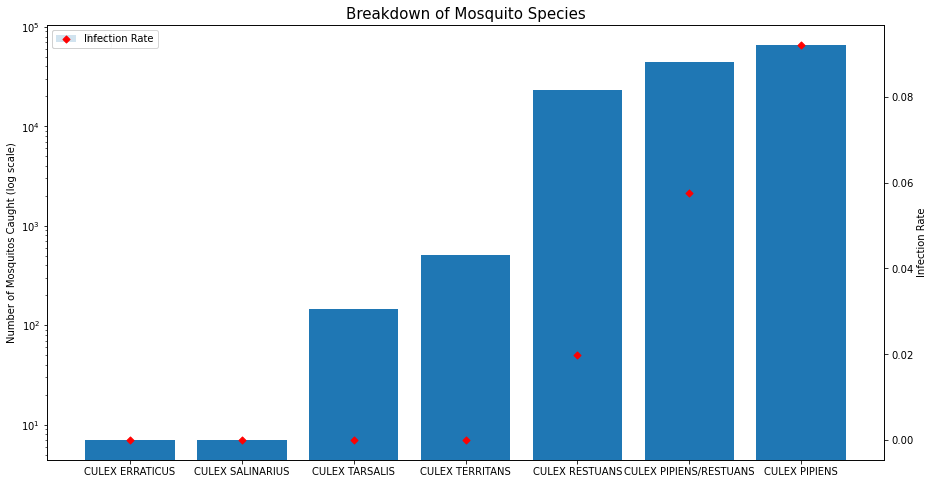

In [7]:
# Number of mosquitos caught based on Species

fig, ax = plt.subplots()

fig.set_size_inches(15,8)

ax.set_yscale('log')

ax.bar(trap_trn.groupby(['Species']).sum().reset_index().sort_values('NumMosquitos')['Species'],
       trap_trn.groupby(['Species']).sum().reset_index().sort_values('NumMosquitos')['NumMosquitos'], label='Total')
ax2 = ax.twinx()
ax2.scatter(species_infection_rate['Species'], species_infection_rate['WnvPresent'], color='r', marker='D', s=25, label='Infection Rate')
ax.set_ylabel('Number of Mosquitos Caught (log scale)')
ax.set_title('Breakdown of Mosquito Species', size=15)
ax2.set_ylabel('Infection Rate')
ax.legend(loc='upper left')
ax2.legend()
plt.show()
#fig.savefig('species_breakdown.png', transparent=True)

#### Trap Analysis

#### Trap Analysis - Mosquitos Caught

Traps T115, T900, T138 and T103 have the highest average number of mosquitos caught. While this might imply that these traps are more effective, further analysis must be conducted to identify if the frequency is due to the location deployed or not.

In [8]:
trap_type_eda = trap_trn.groupby(['Date', 'Address', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
        'WnvPresent', 'Year', 'Month']).sum().reset_index()

In [9]:
# Create dataframe for Trap type analysis

trap_type_mean = trap_type_eda.groupby(['Trap']).mean().reset_index()[['Trap', 'NumMosquitos']]
trap_type_count = trap_type_eda.groupby(['Trap']).count().reset_index()[['Trap', 'NumMosquitos']]
trap_type_total = trap_type_eda.groupby(['Trap']).sum().reset_index()[['Trap', 'NumMosquitos']] 
trap_type = pd.merge(trap_type_mean, trap_type_count, on='Trap')
trap_type = pd.merge(trap_type, trap_type_total, on='Trap')
trap_type.columns = ['Trap', 'Mean', 'Count', 'Sum']
trap_type = trap_type.sort_values('Sum', ascending=False).head(50)

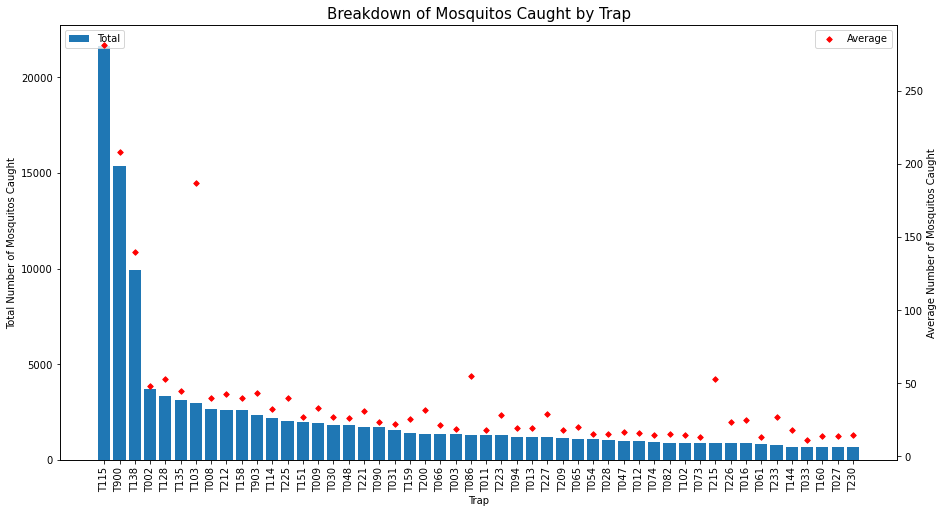

In [10]:
# Breakdown of Mosquitos by Trap type

fig, ax = plt.subplots()

fig.set_size_inches(15,8)

ax.bar(trap_type['Trap'], trap_type['Sum'], label='Total')
ax.set_xlabel('Trap')
ax.set_ylabel('Total Number of Mosquitos Caught')
ax2 = ax.twinx()
ax2.scatter(trap_type['Trap'], trap_type['Mean'], color='r', marker='D', s=15, label='Average')
ax2.set_ylabel('Average Number of Mosquitos Caught')
ax.set_xticklabels(labels=trap_type['Trap'], rotation=90)
ax.set_title('Breakdown of Mosquitos Caught by Trap', size=15)
ax.legend(loc='upper left')
ax2.legend()
plt.show()
#fig.savefig('trap_breakdown.png', transparent=True)

#### Trap Analysis - Infection Rate

Based on the data, there is no clear evidence of any infection rate trend based on the Trap being deployed. This would suggest that the species of mosquito is a more important factor in explaning WnvPresent (instead of Trap).

In [11]:
trap_infection_rate = trap_type_eda.groupby('Trap').mean().reset_index()[['Trap', 'WnvPresent']]
trap_type_infection = pd.merge(trap_type, trap_infection_rate, on='Trap').sort_values('Mean', ascending=False)

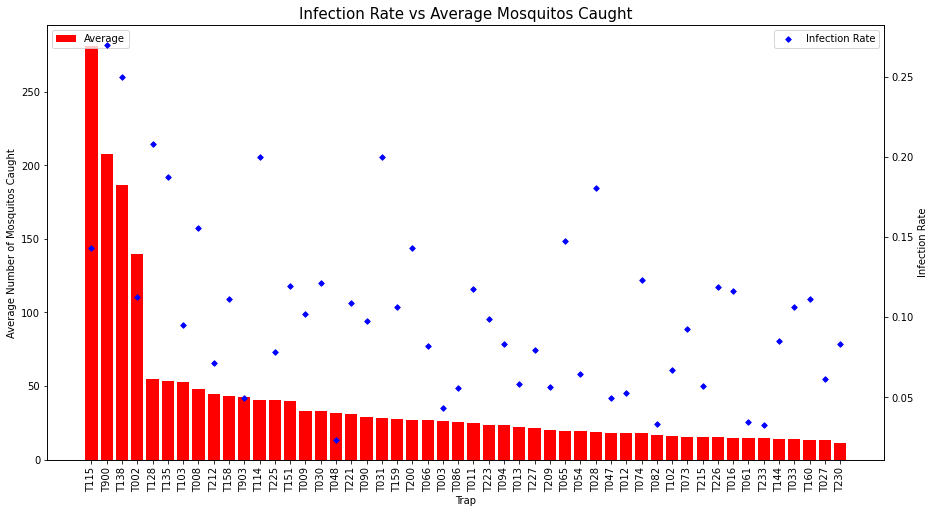

In [12]:
fig, ax = plt.subplots()

fig.set_size_inches(15,8)

ax.bar(trap_type_infection['Trap'], trap_type_infection['Mean'], label='Average', color='r')
ax.set_xlabel('Trap')
ax.set_ylabel('Average Number of Mosquitos Caught')
ax2 = ax.twinx()
ax2.scatter(trap_type_infection['Trap'], trap_type_infection['WnvPresent'], color='b', marker='D', s=15, label='Infection Rate')
ax2.set_ylabel('Infection Rate')
ax.set_xticklabels(labels=trap_type['Trap'], rotation=90)
ax.set_title('Infection Rate vs Average Mosquitos Caught', size=15)
ax.legend(loc='upper left')
ax2.legend()
plt.show()
#fig.savefig('trap_breakdown.png', transparent=True)

#### Location Analysis

The top 20 locations by infection rates are plotted in the bar chart below. Chicago Airport has the highest infection rate.

In [13]:
# Create dataframe for Location analysis

location_eda_infection = trap_type_eda.groupby('AddressNumberAndStreet').mean().reset_index()[['AddressNumberAndStreet', 'WnvPresent']]
location_eda_num = trap_type_eda.groupby('AddressNumberAndStreet').sum().reset_index()[['AddressNumberAndStreet', 'NumMosquitos']]
location_eda = pd.merge(location_eda_infection, location_eda_num, on='AddressNumberAndStreet').sort_values('WnvPresent', ascending=True).tail(20)

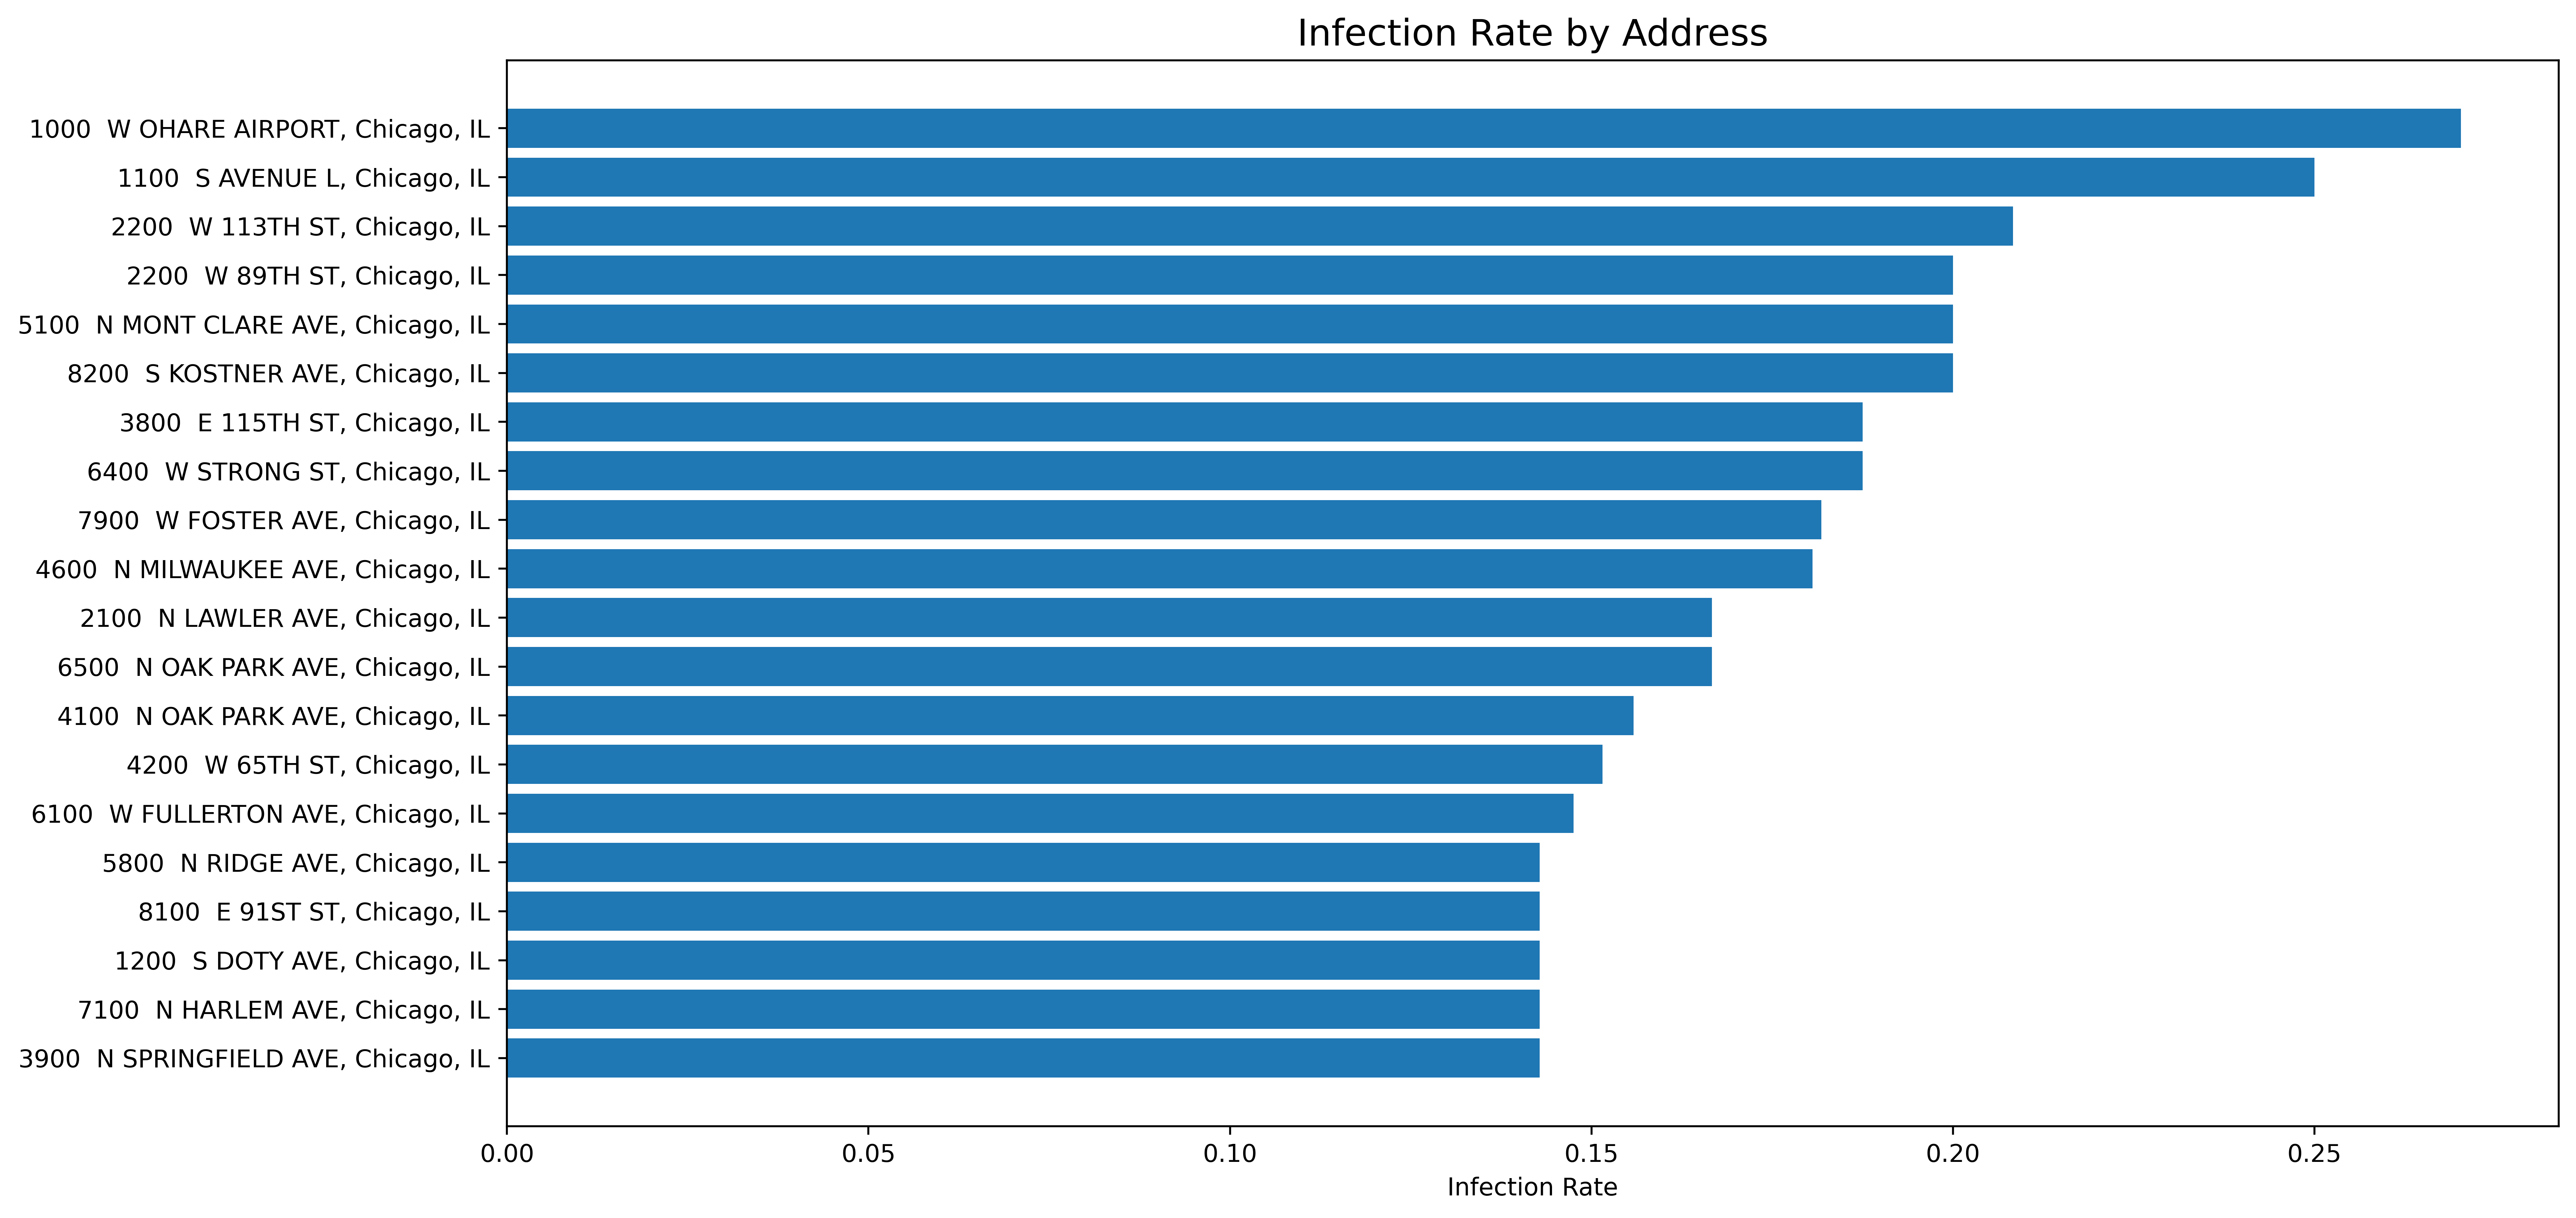

In [14]:
# Breakdown of Infection Rate by Address

fig, ax = plt.subplots()

fig.set_size_inches(15,8)
fig.set_dpi(500)

ax.barh(location_eda['AddressNumberAndStreet'], location_eda['WnvPresent'])
#ax.set_xticklabels(labels=location_eda['AddressNumberAndStreet'], rotation=90)
ax.set_xlabel('Infection Rate')
ax.set_title('Infection Rate by Address', size=15)
plt.show()
#fig.savefig('address_breakdown.png', transparent=True)

### Time Series Analysis

In [15]:
# Create time series dataframe

time_series_trn = trap_trn_eda.groupby('Date').sum()
time_series_trn_year = trap_trn_eda.groupby('Year').mean()
time_series_trn_month = trap_trn_eda.groupby('Month').mean()

#### Infection Rate 

Infection rate is calculated based on the proportion of positive West Nile Virus cases per location (regardless of species type)

In [16]:
# Create dataframe for Infection Rate time series analysis

trap_trn_infection_rate = trap_trn_eda.groupby(['Date', 'Address', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
        'WnvPresent', 'Year', 'Month']).sum().reset_index()
trap_trn_infection_rate['WnvPresent'] = trap_trn_infection_rate['WnvPresent'].apply(lambda x: 1 if x > 0 else 0)
trap_trn_infection_rate['Week'] = trap_trn_infection_rate['Date'].apply(lambda x: x.week)

#### Infection Rate by Week

The data shows that occurences of > 10% infection happens between weeks 29 to 38 (mid-Jul to end-Sep). This implies strong effects of seasonality.

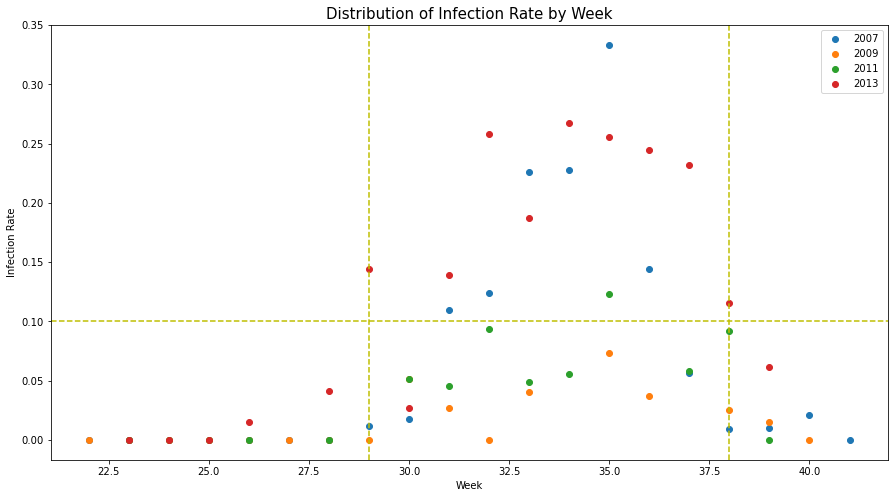

In [17]:
# Breakdown of Infection Rate by Week

infection_rate = trap_trn_infection_rate.groupby(['Week', 'Year']).mean().reset_index()[['Year', 'Week', 'WnvPresent']]

fig, ax = plt.subplots()

fig.set_size_inches(15,8)

for i in [2007, 2009, 2011, 2013]:
    try:
        ax.scatter(infection_rate[infection_rate['Year'] == i]['Week'], 
                   infection_rate[infection_rate['Year'] == i]['WnvPresent'], label=f'{i}')
    except:
        pass
ax.set_xlabel('Week')
ax.set_ylabel('Infection Rate')
ax.set_title('Distribution of Infection Rate by Week', size=15)
ax.axhline(0.1, color='y', linestyle='--')
ax.axvline(38, color='y', linestyle='--')
ax.axvline(29, color='y', linestyle='--')
ax.legend()
plt.show()
#fig.savefig('weeklyinfection.png', transparent=True)

#### Infection Rate by Month

By plotting the infection rates across months, we observe similar trends within years but varying peak infection rates across years. Infection rates were particularly higher in 2007 and 2013.

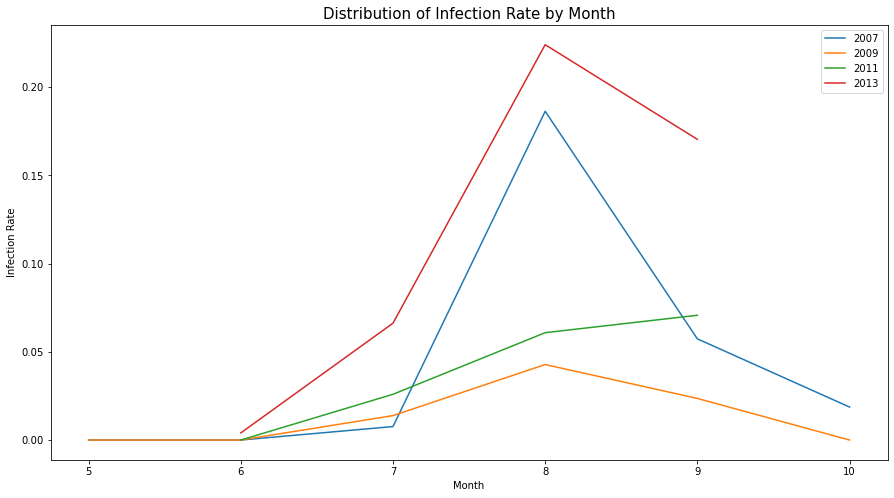

In [18]:
# Breakdown of Infection Rate by Month

infection_rate = trap_trn_infection_rate.groupby(['Month', 'Year']).mean().reset_index()[['Year', 'Month', 'WnvPresent']]

fig, ax = plt.subplots()

fig.set_size_inches(15,8)

for i in [2007, 2009, 2011, 2013]:
    try:
        ax.plot(infection_rate[infection_rate['Year'] == i]['Month'], 
                   infection_rate[infection_rate['Year'] == i]['WnvPresent'], label=f'{i}')
    except:
        pass
    
ax.set_xlabel('Month')
ax.set_ylabel('Infection Rate')
ax.set_title('Distribution of Infection Rate by Month', size=15)
ax.legend()
plt.show()
#fig.savefig('monthlyinfection.png', transparent=True)

## Feature Engineering - Train Data

In [19]:
# Create function to group by count of ten
def group_num_by_ten(num):
    if num <= 10:
        return '1-10'
    elif num <= 20:
        return '11-20'
    elif num <=30:
        return '21-30'
    elif num <=40:
        return '31-40'
    else:
        return '41-50'

In [20]:
# Group the NumMosquito by group of ten
trap_trn['mos_group_num_by_ten'] = trap_trn['NumMosquitos'].apply(group_num_by_ten)

# distance to station 1
# Station 1 location - Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level

trap_trn['Dist_from_station_1'] = ((trap_trn['Latitude']-41.995)**2 + (trap_trn['Longitude']-(-87.933))**2)**0.5

# distance to station 2
# Station 2 location - Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

trap_trn['Dist_from_station_2'] = ((trap_trn['Latitude']-41.786)**2 + (trap_trn['Longitude']-(-87.752))**2)**0.5

In [21]:
# create function to state which station is closer to the trap

def station_proximity(row):
    if row['Dist_from_station_1'] < row['Dist_from_station_2']:
        return 1
    else:
        return 2

In [22]:
# Apply function to state which station is closer to the trap

trap_trn['Station'] = trap_trn.apply(station_proximity, axis=1)

In [23]:
# Create function to get data num
def excel_date(date1):
 
    # Initializing a reference date
    # Note that here date is not 31st Dec but 30th
    temp = datetime.datetime(1899, 12, 30)
    delta = date1 - temp
    return delta.days

In [24]:
# Apply function to get date num
trap_trn['Date_num'] = trap_trn['Date'].apply(excel_date)

In [25]:
# Create function to concatenate station number and date number

def numConcat_stn_date(row):
    station = str(row['Station'])
    date_num = str(row['Date_num'])
    return station + date_num

In [26]:
# Apply function to concatenate station number and date number

trap_trn['Station_datenum'] = trap_trn.apply(numConcat_stn_date, axis=1)

# To check for unique values for trap ID
trap_trn['trap_address'] = trap_trn.Trap+trap_trn.Address

In [27]:
# Create dictionary for the weight for the respective months based on the likelihood of the presence of wnv

month_weight_df = trap_trn.groupby(by=['Month'])['WnvPresent'].mean()
month_weight = {}
for i in range(len(month_weight_df)):
    month_weight[month_weight_df.index[i]] = month_weight_df.values[i]

In [28]:
# Map the weight of the months to the respective rows

trap_trn['Month_w'] = trap_trn['Month'].map(month_weight)

In [29]:
# Create dictionary for the weight for the respective address/location based on the likelihood of the presence of wnv

address_weight_df = trap_trn.groupby(by=['Address'])['WnvPresent'].mean()
address_weight = {}
for i in range(len(address_weight_df)):
    address_weight[address_weight_df.index[i]] = address_weight_df.values[i]

In [30]:
# Map the weight of the address to the respective rows

trap_trn['Address_w'] = trap_trn['Address'].map(address_weight)

In [31]:
# Create dictionary for the weight for the respective mosquito species based on the likelihood of the presence of wnv

species_weight_df = trap_trn.groupby(by=['Species'])['WnvPresent'].mean()
species_weight = {}
for i in range(len(species_weight_df)):
    species_weight[species_weight_df.index[i]] = species_weight_df.values[i]

In [32]:
# Map the weight of the species to the respective rows

trap_trn['Species_w'] = trap_trn['Species'].map(species_weight)

# Feature Engineering - Weather Data

In [33]:
# load data from weather dataset

weather = pd.read_csv('data/datasets/weather_clean.csv')
weather['Date'] = pd.to_datetime(weather['Date'])

In [34]:
# Function to calculate relative humidity

def cal_r_humidity(row):
    temp_celsius = (5/9)*(row['Tavg']-32)
    std_vp = 6.11*10*((7.5*temp_celsius)/(237.3+temp_celsius))
    dew_pt_celsius = (5/9)*(row['DewPoint']-32)
    actual_vp = 6.11*10*((7.5*dew_pt_celsius)/(237.3+dew_pt_celsius))
    rh = (actual_vp*100)/std_vp
    return rh

In [35]:
# Apply function to determine the relative humidity for each entry

weather['r_humidity'] = weather.apply(cal_r_humidity, axis=1)

In [36]:
# Store weather data for station 1 in df

weather_stn1 = weather[weather.Station == 1]

In [37]:
# Set index as date and sort value

weather_stn1.set_index('Date', inplace=True)
weather_stn1.sort_index(inplace = True)

In [38]:
# To get the average weather data for the past 14 days
weather_stn1_14daysavg = weather_stn1.rolling(14).mean()

# To drop NA
weather_stn1_14daysavg.dropna(inplace=True)

# Rename the column name
col_name = ['Station']

for name in weather_stn1_14daysavg.columns[1:]:
    col_name.append(name + '_14daysavg')
    
weather_stn1_14daysavg.columns = col_name

# Return Date to column
weather_stn1_14daysavg.reset_index(level=0, inplace=True)

weather_stn1_14daysavg.head()

,Date,Station,Tmax_14daysavg,Tmin_14daysavg,Tavg_14daysavg,Depart_14daysavg,DewPoint_14daysavg,WetBulb_14daysavg,Heat_14daysavg,Cool_14daysavg,Sunrise_14daysavg,Sunset_14daysavg,PrecipTotal_14daysavg,StnPressure_14daysavg,SeaLevel_14daysavg,ResultSpeed_14daysavg,ResultDir_14daysavg,AvgSpeed_14daysavg,r_humidity_14daysavg
0,2007-05-14,1.0,73.357143,50.214286,62.000000,6.428571,43.571429,52.642857,4.571429,1.571429,440.214286,1864.714286,0.009286,29.340714,30.066429,9.000000,11.428571,10.721429,37.447274
1,2007-05-15,1.0,73.142857,50.714286,62.142857,6.214286,43.928571,53.000000,4.571429,1.714286,439.071429,1868.642857,0.036429,29.342857,30.067857,9.457143,11.428571,10.942857,38.197376
2,2007-05-16,1.0,73.642857,50.857143,62.428571,6.142857,44.000000,53.071429,4.285714,1.714286,437.928571,1872.571429,0.046429,29.339286,30.063571,9.085714,13.714286,10.857143,37.870290
3,2007-05-17,1.0,73.357143,50.642857,62.214286,5.571429,43.428571,52.714286,4.500000,1.714286,436.785714,1876.500000,0.046429,29.350714,30.074286,9.000000,13.428571,10.814286,35.401791
4,2007-05-18,1.0,73.714286,50.142857,62.142857,5.071429,42.642857,52.428571,4.571429,1.714286,435.714286,1880.428571,0.046429,29.366429,30.088571,8.642857,14.642857,10.578571,32.225169


In [39]:
# Store weather data for station 2 in df

weather_stn2 = weather[weather.Station == 2]

In [40]:
# Set index as date and sort value

weather_stn2.set_index('Date', inplace=True)
weather_stn2.sort_index(inplace = True)

In [41]:
# To get the average weather data for the past 14 days
weather_stn2_14daysavg = weather_stn2.rolling(14).mean()

# To drop NA
weather_stn2_14daysavg.dropna(inplace=True)

# Rename the column name
col_name = ['Station']

for name in weather_stn2_14daysavg.columns[1:]:
    col_name.append(name + '_14daysavg')
    
weather_stn2_14daysavg.columns = col_name

# Return Date to column
weather_stn2_14daysavg.reset_index(level=0, inplace=True)

In [42]:
# Combine weather data for station 1 and station 2 for 14daysavg
weather_14daysavg = pd.concat([weather_stn1_14daysavg,weather_stn2_14daysavg], axis = 0, ignore_index=True)

In [43]:
# Create unique identifier 'Station_datenum' to map weather data to train and test dataset

weather['Date_num'] = weather['Date'].apply(excel_date)
weather['Station_datenum'] = weather.apply(numConcat_stn_date, axis=1)
weather.drop(['Station','Date','Date_num'], axis=1, inplace=True)

# Create unique identifier 'Station_datenum' to map weather data to train and test dataset

weather_14daysavg['Date_num'] = weather_14daysavg['Date'].apply(excel_date)
weather_14daysavg['Station'] = weather_14daysavg['Station'].astype(int)
weather_14daysavg['Station_datenum'] = weather_14daysavg.apply(numConcat_stn_date, axis=1)
weather_14daysavg.drop(['Date','Station','Date_num'], axis=1, inplace=True)

# Exploratory Data Analysis - Weather Data

## Temperature Analysis (by week)

Average temperatures peak between week 27 and 36. This shows a two week lag between peak temperatures and peak infection rates. An explanation for this could be due to the mosquito breeding cycle which lasts 7-10 days. Hence, the previous 14-day average temperatures would have likely been the period during which mosquito breeding takes place.



In [44]:
# Create dataframe for weather EDA

weather_eda = weather_stn1.copy().reset_index()
weather_eda['Year'] = weather_eda['Date'].apply(lambda x: x.year)
weather_eda['date_month'] = weather_eda['Date'].apply(lambda x: x.strftime('%m-%d'))
weather_eda['Week'] = weather_eda['Date'].apply(lambda x: x.week)
weather_eda_weekly = weather_eda.groupby(['Year', 'Week']).mean().reset_index()

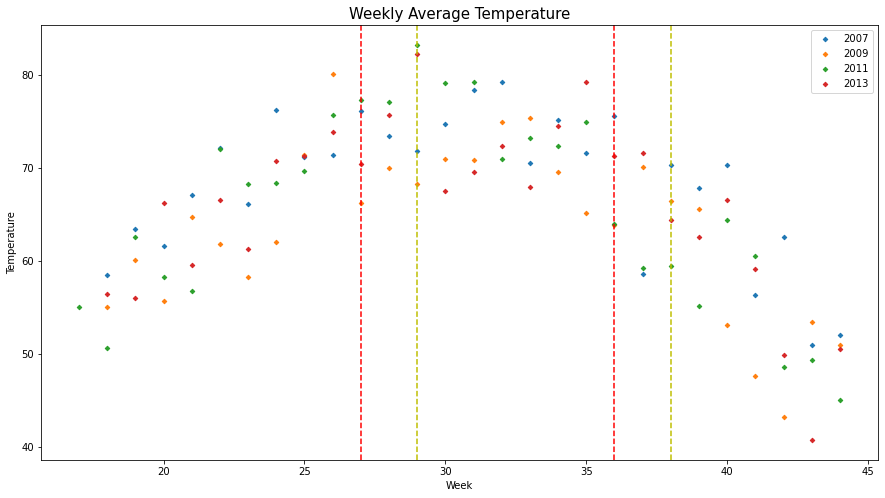

In [45]:
fig, ax = plt.subplots()

fig.set_size_inches(15,8)

for i in [2007, 2009, 2011, 2013]:
    try:
        ax.scatter(weather_eda_weekly[weather_eda_weekly['Year'] == i]['Week'], 
                   weather_eda_weekly[weather_eda_weekly['Year'] == i]['Tavg'], label=f'{i}', marker='D', s=10)
    except:
        pass
ax.legend()
ax.axvline(38, color='y', linestyle='--')
ax.axvline(29, color='y', linestyle='--')
ax.axvline(36, color='r', linestyle='--')
ax.axvline(27, color='r', linestyle='--')
ax.set_xlabel('Week')
ax.set_ylabel('Temperature')
ax.set_title('Weekly Average Temperature', size=15)
plt.show()
#fig.savefig('weeklytemp.png', transparent=True)

## Precipitation Analysis (by week)

If we look at the same peak infection period, there does not appear to be evidence of any difference in precipitation trends. Chicago experiences 0.135 inches of rain per day.

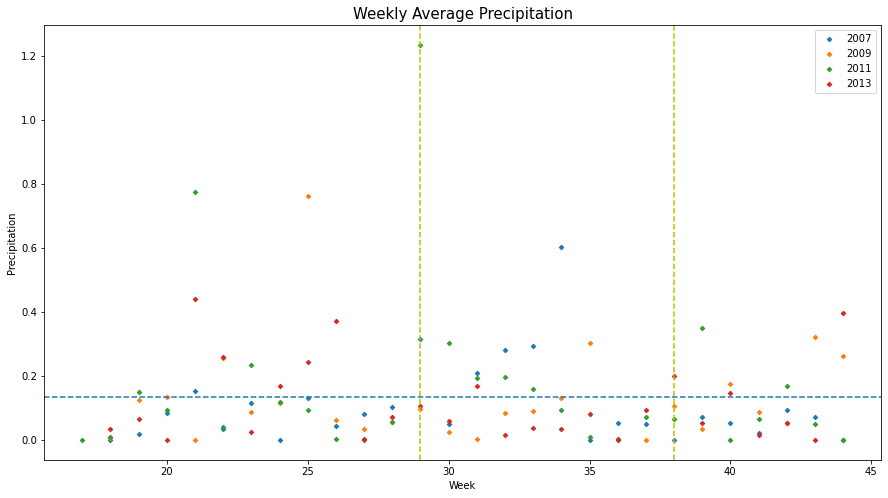

In [46]:
fig, ax = plt.subplots()

fig.set_size_inches(15,8)

for i in [2007, 2009, 2011, 2013]:
    try:
        ax.scatter(weather_eda_weekly[weather_eda_weekly['Year'] == i]['Week'], 
                   weather_eda_weekly[weather_eda_weekly['Year'] == i]['PrecipTotal'], label=f'{i}', marker='D', s=10)
    except:
        pass
ax.legend()
ax.axvline(38, color='y', linestyle='--')
ax.axvline(29, color='y', linestyle='--')
ax.axhline(weather_eda['PrecipTotal'].mean(), linestyle='--')
ax.set_xlabel('Week')
ax.set_ylabel('Precipitation')
ax.set_title('Weekly Average Precipitation', size=15)
plt.show()
#fig.savefig('weeklyprecip.png', transparent=True)

## Temperature Analysis (14-day MA)

Having identified the seasonality impact within years, we try to identify what causes the variation across years. Plotting the 14-day moving average shows us that there is no distinct patterns in temperature trends across the 4 years of data. There is no clear evidence that 2007 and 2013 experienced consistently higher temperatures.

In [47]:
# Create dataframe for inter-year analysis

weather_eda_day = weather_stn1_14daysavg.copy().reset_index()
weather_eda_day['Year'] = weather_eda_day['Date'].apply(lambda x: x.year)
weather_eda_day['date_month'] = weather_eda_day['Date'].apply(lambda x: x.strftime('%m-%d'))
weather_eda_day['date_month'].value_counts().tail(20)
remove_date_month = ['05-01', '05-02', '05-03', '05-04', '05-05', '05-06', '05-07', '05-08', '05-09', '05-10',
                     '05-11', '05-12', '05-13']
for i in range(len(weather_eda_day)):
    if weather_eda_day['date_month'][i] in remove_date_month:
        weather_eda_day.drop(i, inplace=True)
    else:
        pass

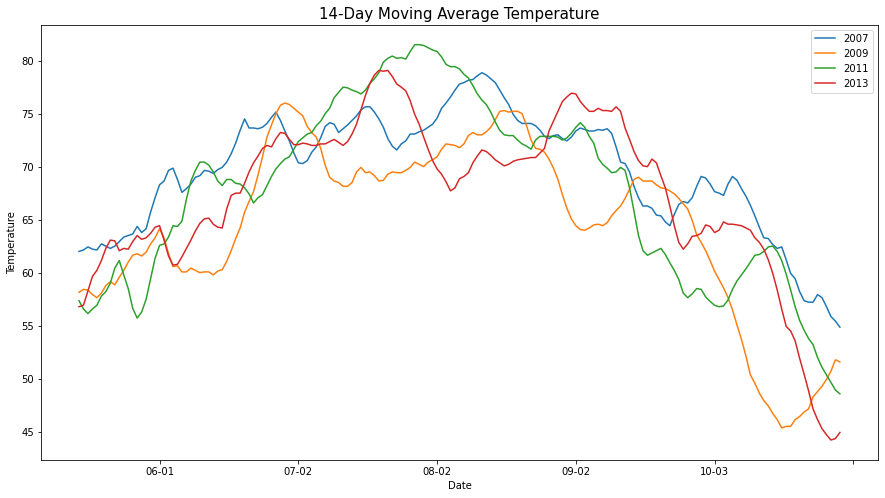

In [48]:
# Breakdown of 14-day MA temperature across years

fig, ax = plt.subplots()

fig.set_size_inches(15,8)

for i in [2007, 2009, 2011, 2013]:
    try:
        ax.plot(weather_eda_day[weather_eda_day['Year'] == i]['date_month'], 
                   weather_eda_day[weather_eda_day['Year'] == i]['Tavg_14daysavg'], label=f'{i}')
    except:
        pass
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.set_title('14-Day Moving Average Temperature', size=15)
ax.set_xticks(np.arange(18, 184, 31))

plt.show()
#fig.savefig('14matemp.png', transparent=True)

# Merge Train and Weather Datasets

In [49]:
trap_trn_weather_full = pd.merge(trap_trn, weather, on='Station_datenum')
trap_trn_weather_full = pd.merge(trap_trn_weather_full, weather_14daysavg, on='Station_datenum')


# Exploratory Data Analysis - Train + Weather Data

In [50]:
# Create dataframe to analyse infection rate against weather data

group_columns = list(trap_trn_weather_full.columns)

for i in ['NumMosquitos', 'Species', 'mos_group_num_by_ten', 'Species_w']:
    group_columns.remove(i)
    
trap_trn_weather_full_eda = trap_trn_weather_full.drop(['mos_group_num_by_ten', 'Species_w'], axis=1).groupby(group_columns).sum().reset_index()

## Infection Rate vs Temperature

The majority of cases where infection rate is > 10% occurs when temperatures are above 69F.

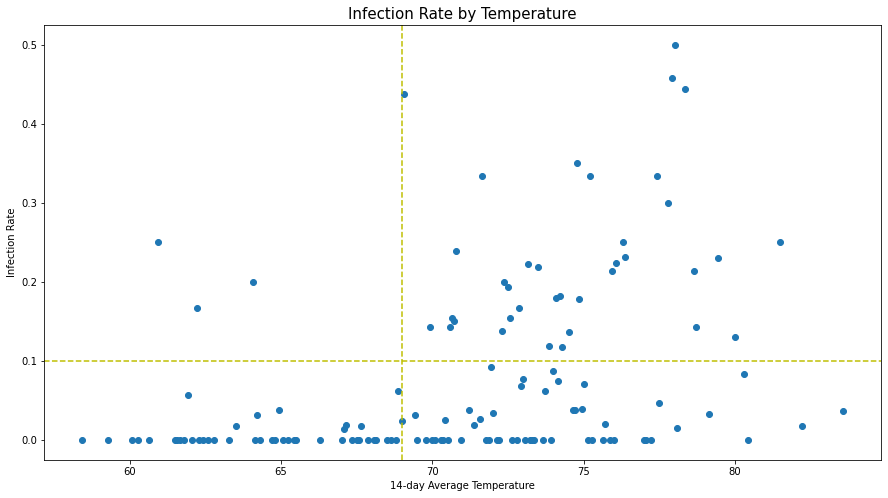

In [51]:
# Breakdown of infection rate by 14-day average temperature

tavg_wnv_eda = trap_trn_weather_full_eda.groupby(['Tavg_14daysavg']).mean().reset_index()

fig, ax = plt.subplots()

fig.set_size_inches(15,8)
    
ax.scatter(tavg_wnv_eda['Tavg_14daysavg'], tavg_wnv_eda['WnvPresent'])
ax.set_xlabel('14-day Average Temperature')
ax.set_ylabel('Infection Rate')
ax.set_title('Infection Rate by Temperature', size=15)
ax.axvline(69, color='y', linestyle='--')
ax.axhline(0.1, color='y', linestyle='--')
plt.show()
#fig.savefig('temp_infection.png', transparent=True)

## Infection Rate vs Wet Bulb Temperature

Similar to temperature, the infection rates > 10% are more common at higher Wet Bulb temperatures (above 62F).

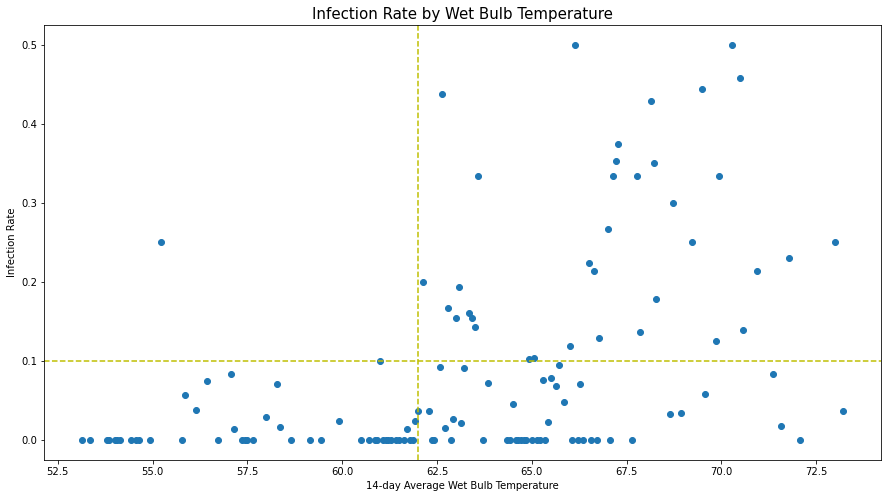

In [52]:
# Breakdown of infection rates by 14-day average temperature

wetbulb_wnv_eda = trap_trn_weather_full_eda.groupby(['WetBulb_14daysavg']).mean().reset_index()

fig, ax = plt.subplots()

fig.set_size_inches(15,8)

ax.scatter(wetbulb_wnv_eda['WetBulb_14daysavg'], wetbulb_wnv_eda['WnvPresent'])
ax.set_xlabel('14-day Average Wet Bulb Temperature')
ax.set_ylabel('Infection Rate')
ax.set_title('Infection Rate by Wet Bulb Temperature', size=15)
ax.axvline(62, color='y', linestyle='--')
ax.axhline(0.1, color='y', linestyle='--')

## Infection Rate vs Precipitation

There are no clear trends between infection rates and precipitation. This is likely due to the fact that Chicago experiences relatively consistent rainfall across the year. 

Text(0.5, 1.0, 'Infection Rate by Precipitation')

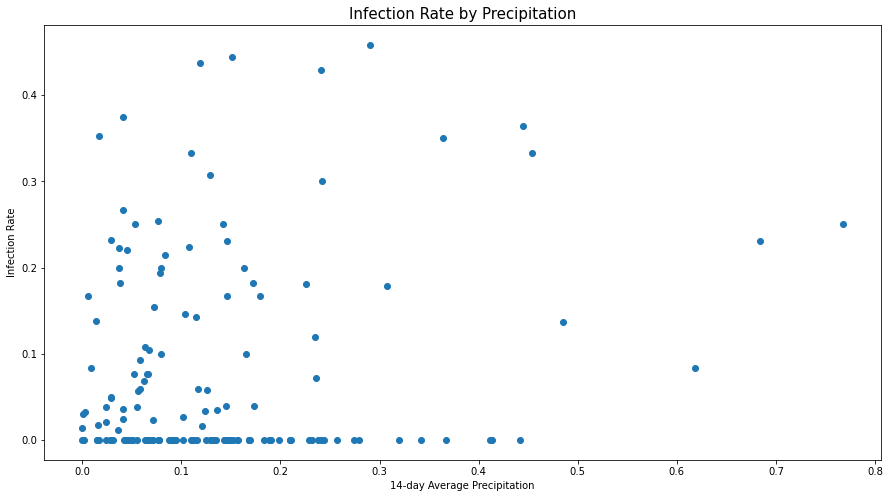

In [53]:
# Breakdown of infection rates by 14-day average precipiration

precip_wnv_eda = trap_trn_weather_full_eda.groupby(['PrecipTotal_14daysavg']).mean().reset_index()

fig, ax = plt.subplots()

fig.set_size_inches(15,8)

ax.scatter(precip_wnv_eda['PrecipTotal_14daysavg'], precip_wnv_eda['WnvPresent'])
ax.set_xlabel('14-day Average Precipitation')
ax.set_ylabel('Infection Rate')
ax.set_title('Infection Rate by Precipitation', size=15)

## Infection Rate vs Precipitation

There are no clear trends between infection rates and wind speed. Intuitively, there does not seem to be much relevance between mosquito breeding and wind speeds.

Text(0.5, 1.0, 'Infection Rate by Wind Speed')

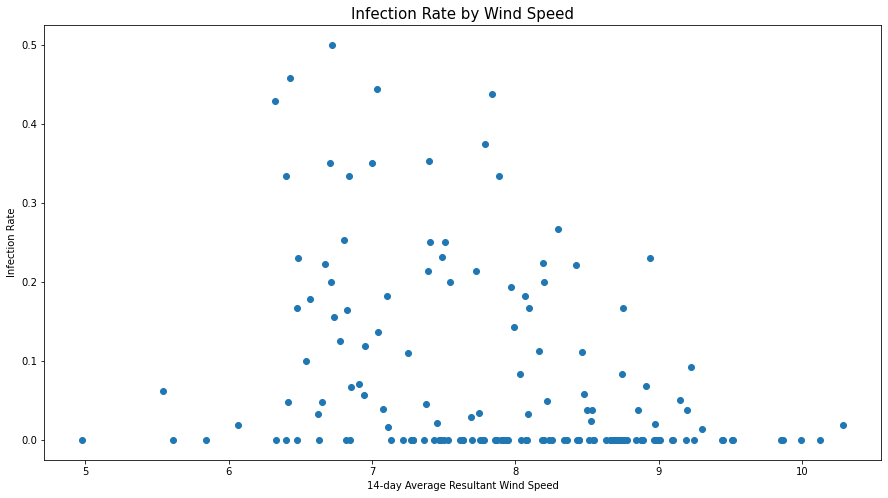

In [54]:
# Breakdown of infection rates by 14-day average precipiration

avgspeed_wnv_eda = trap_trn_weather_full_eda.groupby(['AvgSpeed_14daysavg']).mean().reset_index()

fig, ax = plt.subplots()

fig.set_size_inches(15,8)

ax.scatter(avgspeed_wnv_eda['AvgSpeed_14daysavg'], avgspeed_wnv_eda['WnvPresent'])
ax.set_xlabel('14-day Average Resultant Wind Speed')
ax.set_ylabel('Infection Rate')
ax.set_title('Infection Rate by Wind Speed', size=15)

## Features Selection

From the exploratory data analysis, we have identified factors such as address, mosquito species, month as well as weather conditions and they are likely to impact the presence of west nile virus in mosquitoes. These factors generally affect the breeding of the mosquitoes and their activities. Certain areas and weather conditions are more ideal for mosquito breeding. In addition, studies have shown that the infection rate of wnv depends on the ecology, which may have resulted in the observed seasonality. Studies have also shown that mosquito species even within the family of culex have varied competency as a vector of west nile virus.

Source: Relative Influence of Land Use, Mosquito Abundance, and Bird Communities in Defining West Nile Virus Infection Rates in 
Culex Mosquito Populations (https://www.mdpi.com/2075-4450/13/9/758)

In [55]:
## List of selected features

sel_features = ['Address_w', 'Month_w', 'DewPoint_14daysavg',
                'r_humidity_14daysavg', 'Species_w', 'Cool_14daysavg', 'WetBulb_14daysavg',
                'PrecipTotal_14daysavg','ResultSpeed_14daysavg', 'AvgSpeed_14daysavg', 'Tavg_14daysavg'] 



## Train Data with selected features

In [56]:
## Save train data with selected features to csv

trap_trn_weather_sel_feat = pd.concat([trap_trn_weather_full[sel_features],
                                       trap_trn_weather_full[['WnvPresent','Address','Month']]],axis=1)

trap_trn_weather_sel_feat.to_csv('data/datasets/trap_trn_weather_sel_feat.csv', index=False)

## Test Data with selected features

In [57]:
# Load test data

trap_test = pd.read_csv('data/datasets/test.csv')
trap_test['Date'] = pd.to_datetime(trap_test['Date'])

# Create features

trap_test['Year'] = trap_test.Date.dt.year
trap_test['Month'] = trap_test.Date.dt.month

In [58]:
# Display the difference of the values in train and test datasets

for column in trap_test.columns[2:11]:
    print(column)
    print(set(trap_test[column]) - set(trap_trn[column]))
    print('\n')

Address
{'4600 North Melvina Avenue, Chicago, IL 60630, USA', '1100 South Loomis Street, Chicago, IL 60607, USA', '3400 North Long Avenue, Chicago, IL 60641, USA', '1200 West 120th Street, Chicago, IL 60643, USA', '2600 East 136th Street, Chicago, IL 60633, USA', '1400 West 112th Street, Chicago, IL 60643, USA', 'South Oglesby Avenue, Chicago, IL, USA', '3700 North Kilbourn Avenue, Chicago, IL 60641, USA', '5100 West 63rd Place, Chicago, IL 60638, USA', '6500 West Dakin Street, Chicago, IL 60634, USA', '2900 North Kenneth Avenue, Chicago, IL 60641, USA', 'South Baltimore Avenue, Chicago, IL 60617, USA', '4000 North Kedvale Avenue, Chicago, IL 60641, USA'}


Species
{'UNSPECIFIED CULEX'}


Block
{26}


Street
{' W 112TH ST', ' E 136TH ST', ' W 63RD PL', ' S OGLESBY AVE', ' W 120TH ST', ' S BALTIMORE AVE', ' N KILBOURN AVE', ' W DAKIN ST', ' N MELVINA AVE', ' S LOOMIS ST', ' N KENNETH AVE'}


Trap
{'T090A', 'T090B', 'T002A', 'T234', 'T218A', 'T065A', 'T200B', 'T218C', 'T218B', 'T002B', '

#### Observations
Certain address and species are missing in test dataset. 

In [59]:
# To impute missing values using KNN on the location

knn_address = KNeighborsClassifier(n_neighbors=5)
knn_address.fit(trap_trn[['Latitude','Longitude']], trap_trn.Address)
trap_test['Address'] = knn_address.predict(trap_test[['Latitude','Longitude']])

In [60]:
# Map the weight of the address to the respective rows

trap_test['Address_w'] = trap_test['Address'].map(address_weight)

In [61]:
# To impute missing values using KNN on the mosquito species

knn_species = KNeighborsClassifier(n_neighbors=5)
knn_species.fit(trap_trn[['Latitude','Longitude']], trap_trn.Species)
trap_test['Species'] = knn_species.predict(trap_test[['Latitude','Longitude']])

In [62]:
# Map the weight of the mosquito species to the respective rows

trap_test['Species_w'] = trap_test['Species'].map(species_weight)

In [63]:
# Map the weight of the weight to the respective rows

trap_test['Month_w'] = trap_test['Month'].map(month_weight)

In [64]:
# distance to station 1
# Station 1 location - Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level

trap_test['Dist_from_station_1'] = ((trap_test['Latitude']-41.995)**2 + (trap_test['Longitude']-(-87.933))**2)**0.5

# distance to station 2
# Station 2 location - Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

trap_test['Dist_from_station_2'] = ((trap_test['Latitude']-41.786)**2 + (trap_test['Longitude']-(-87.752))**2)**0.5

In [65]:
# Apply function to state which station is closer to the trap

trap_test['Station'] = trap_test.apply(station_proximity, axis=1)

In [66]:
# Apply function to get date number

trap_test['Date_num'] = trap_test['Date'].apply(excel_date)

In [67]:
# Apply function to concatenate station number and date number

trap_test['Station_datenum'] = trap_test.apply(numConcat_stn_date, axis=1)

In [68]:
# Merge weather dataset with test dataset

trap_test_weather_full = pd.merge(trap_test, weather, on='Station_datenum')
trap_test_weather_full = pd.merge(trap_test_weather_full, weather_14daysavg, on='Station_datenum')

In [69]:
## Save train data with selected features to csv

trap_test_weather_sel_feat = trap_test_weather_full[sel_features]
trap_test_weather_sel_feat = pd.concat([trap_test_weather_full[sel_features],trap_test[['Id']]],axis=1)
trap_test_weather_sel_feat.to_csv('data/datasets/trap_test_weather_sel_feat.csv', index=False)